In [205]:
cd "./dataset/data"

[Errno 2] No such file or directory: './dataset/data'
/home/jupyter/cse519_project/dataset/data


In [206]:
pip install reverse_geocoder pytz timezonefinder --user

Note: you may need to restart the kernel to use updated packages.


import os
for root, dirs, files in os.walk('.'):
    print(root, dirs, files)

In [207]:
import os

files_list = []

for root, dirs, files in os.walk("."):
    for file in files:
        if file.endswith(".json"):
             files_list.append(str(os.path.join(root, file)))

In [208]:
import json
import pandas as pd

geos = pd.DataFrame([])

geo_cnt = 0
place_cnt = 0
user_loc_cnt = 0

for file_name in files_list:
    temp = pd.read_json(file_name, orient='records',convert_dates=False)
    geos = pd.concat([geos,temp], ignore_index=True)

In [209]:
def fill_coordinates(row):
    try:
        coordinates = row['place']['bounding_box']['coordinates']
        return (coordinates[0][0][1], coordinates[0][0][0])
    except:
        return None

geos['coordinate'] = geos.apply(fill_coordinates, axis = 1)

In [210]:
geos.dropna(inplace=True)
geos.drop(columns=['place'], inplace=True)

In [211]:
coords = geos['coordinate'].tolist()
coords = tuple(coords)

import reverse_geocoder as rg
results = rg.search(coords)

country = []
state = []

for rec in results:
    country.append(rec['cc'])
    state.append(rec['admin1'])

country = pd.Series(country)
state = pd.Series(state)

In [212]:
geos['country'] = country
geos['state'] = state
geos.dropna(inplace=True)

In [213]:
from timezonefinder import TimezoneFinder
import datetime
import pytz

tf = TimezoneFinder()

def get_localtime_in_seconds(rows):
    coor = rows['coordinate']
    lati = coor[0]
    logi = coor[1]
    zone_str = tf.timezone_at(lng = logi, lat = lati)
    if zone_str == None:
        return None, None, None, None
    d = datetime.datetime.fromtimestamp(rows['timestamp_ms']/1000, tz=pytz.timezone(zone_str))
    h, m, s = d.hour, d.minute, d.second
    month, weekday, day_in_month = d.month, d.weekday(), d.day
    return h*3600+m*60+s, month, weekday, day_in_month

geos['time_in_second'], geos['month'], geos['weekday'], geos['day_in_month'] = zip(*geos.apply(get_localtime_in_seconds, axis=1))
geos

,user_id,timestamp_ms,coordinate,country,state,time_in_second,month,weekday,day_in_month
0,736831058906349568,1586527800666,"(25.209613, 49.416654)",SA,Eastern Province,61800,4,4,10
1,871377789764685824,1586527801661,"(-20.399866, -40.606199)",BR,Espirito Santo,40201,4,4,10
2,838134445068668930,1586527802666,"(-23.08302, -43.795449)",BR,Rio de Janeiro,40202,4,4,10
3,140442459,1586527802658,"(18.845343, 72.74484)",IN,Maharashtra,70802,4,4,10
4,306124870,1586527806666,"(55.894729, -3.328512)",GB,Scotland,54606,4,4,10
...,...,...,...,...,...,...,...,...,...
1363360,3404591973,1585723400660,"(28.250764, -81.47749)",JP,Fukuoka,9800,4,2,1
1363361,148940626,1585723401663,"(19.357102, -99.191996)",BR,Rio Grande do Sul,2601,4,2,1
1363362,2304015812,1585723405663,"(-22.814792, -43.410273)",ZA,Western Cape,13405,4,2,1
1363363,302237789,1585723414664,"(23.532013, 115.834717)",PH,,53014,4,2,1


In [214]:
geos.dropna(inplace=True)

In [215]:
def get_label(row):
    t = row['time_in_second']
    # every 15 minute
    return t//(15*60)

geos['label'] = geos.apply(get_label, axis=1)
geos

,user_id,timestamp_ms,coordinate,country,state,time_in_second,month,weekday,day_in_month,label
0,736831058906349568,1586527800666,"(25.209613, 49.416654)",SA,Eastern Province,61800,4,4,10,68
1,871377789764685824,1586527801661,"(-20.399866, -40.606199)",BR,Espirito Santo,40201,4,4,10,44
2,838134445068668930,1586527802666,"(-23.08302, -43.795449)",BR,Rio de Janeiro,40202,4,4,10,44
3,140442459,1586527802658,"(18.845343, 72.74484)",IN,Maharashtra,70802,4,4,10,78
4,306124870,1586527806666,"(55.894729, -3.328512)",GB,Scotland,54606,4,4,10,60
...,...,...,...,...,...,...,...,...,...,...
1363360,3404591973,1585723400660,"(28.250764, -81.47749)",JP,Fukuoka,9800,4,2,1,10
1363361,148940626,1585723401663,"(19.357102, -99.191996)",BR,Rio Grande do Sul,2601,4,2,1,2
1363362,2304015812,1585723405663,"(-22.814792, -43.410273)",ZA,Western Cape,13405,4,2,1,14
1363363,302237789,1585723414664,"(23.532013, 115.834717)",PH,,53014,4,2,1,58


In [216]:
# select US only data
geos = geos.loc[geos.country=='US']
geos.reset_index(inplace = True)
geos

,index,user_id,timestamp_ms,coordinate,country,state,time_in_second,month,weekday,day_in_month,label
0,5,1139323604330569729,1586527809663,"(41.481426, -87.674421)",US,Illinois,33009,4,4,10,36
1,10,27377135,1586527816658,"(33.606077, -117.86894)",US,California,25816,4,4,10,28
2,11,515108272,1586527817665,"(30.355644, -85.605166)",US,Florida,33017,4,4,10,36
3,15,118811691,1586527831663,"(40.361580000000004, -80.095586)",US,Pennsylvania,36631,4,4,10,40
4,24,1185068084010180608,1586527838658,"(36.992427, -109.060257)",US,Colorado,29438,4,4,10,32
...,...,...,...,...,...,...,...,...,...,...,...
302899,1363329,499725537,1585723214662,"(7.299143, 3.777011)",US,California,27614,4,2,1,30
302900,1363333,437390598,1585723219661,"(6.482676, 3.198942)",US,California,27619,4,2,1,30
302901,1363334,60419030,1585723220662,"(-24.008814, -46.826039)",US,Oklahoma,13220,4,2,1,14
302902,1363344,742373012226244608,1585723244666,"(13.586457, 100.472022)",US,Illinois,49244,4,2,1,54


__Compute the duration in state level__

In [217]:
import numpy as np
from sklearn.neighbors import KernelDensity

def state_level_month_low_act_duration(state):
    print(state)
    # bin 24 hrs in 15 min interval
    X = np.linspace(0,95,96)
    state_lable = np.array(geos[geos['state']==state]['label'])
    mirror_state_lable = state_lable*-1
    new_state_lable = np.concatenate((mirror_state_lable,state_lable))
    # optim_width calculation
    optim_width = 1.06*new_state_lable.std()*np.power(len(new_state_lable),-0.2)
    bw = optim_width
    kde=KernelDensity(kernel='gaussian',bandwidth=bw).fit(new_state_lable.reshape(-1, 1))
    log_pdf = kde.score_samples(X.reshape(-1,1))
    pdf=np.exp(log_pdf)
    
    # trough_period in hour
    trough_period = X[pdf <0.8*np.median(pdf)]/4
    try:
        low_activity_duration = trough_period.max() - trough_period.min()
    except:
        return 0
    # return low activity duration, when it starts, when it ends
    return low_activity_duration, trough_period.min(), trough_period.max()

    

In [218]:
state_list = list(geos.state.unique())

In [219]:
low_act_duration_state_dict = {}

for state in state_list:
    low_act_duration, start, end = state_level_month_low_act_duration(state)
    low_act_duration_state_dict[state] = {'duration': low_act_duration, 'start': start, 'end': end}

Illinois
California
Florida
Pennsylvania
Colorado
Minnesota
Kansas
Wisconsin
Washington
Texas
North Carolina
Alaska
Ohio
Missouri
New York
Alabama
Tennessee
Oregon
Virginia
New Jersey
Nebraska
Michigan
New Mexico
Massachusetts
Maryland
South Carolina
West Virginia
Georgia
Rhode Island
Indiana
Oklahoma
Iowa
Louisiana
Arkansas
Delaware
Utah
Maine
Connecticut
South Dakota
Arizona
Kentucky
Mississippi
Nevada
New Hampshire
Idaho
Vermont
Montana
Hawaii
North Dakota
Wyoming
Washington, D.C.


In [220]:
low_act_duration_state_dict

{'Illinois': {'duration': 7.75, 'start': 1.5, 'end': 9.25},
 'California': {'duration': 7.75, 'start': 2.25, 'end': 10.0},
 'Florida': {'duration': 8.25, 'start': 1.25, 'end': 9.5},
 'Pennsylvania': {'duration': 9.5, 'start': 0.0, 'end': 9.5},
 'Colorado': {'duration': 8.25, 'start': 1.25, 'end': 9.5},
 'Minnesota': {'duration': 9.25, 'start': 0.0, 'end': 9.25},
 'Kansas': {'duration': 9.25, 'start': 0.0, 'end': 9.25},
 'Wisconsin': {'duration': 9.5, 'start': 0.0, 'end': 9.5},
 'Washington': {'duration': 7.5, 'start': 2.0, 'end': 9.5},
 'Texas': {'duration': 7.75, 'start': 2.0, 'end': 9.75},
 'North Carolina': {'duration': 9.5, 'start': 0.0, 'end': 9.5},
 'Alaska': {'duration': 4.25, 'start': 2.75, 'end': 7.0},
 'Ohio': {'duration': 9.5, 'start': 0.0, 'end': 9.5},
 'Missouri': {'duration': 9.5, 'start': 0.0, 'end': 9.5},
 'New York': {'duration': 8.5, 'start': 1.0, 'end': 9.5},
 'Alabama': {'duration': 9.0, 'start': 0.0, 'end': 9.0},
 'Tennessee': {'duration': 9.5, 'start': 0.0, 'end':

pip install plotly --user

In [221]:
state_dict = {
    'Illinois': 'IL',
    'California': 'CA',
    'Florida': 'FL',
    'Pennsylvania': 'PA',
    'Colorado': 'CO',
    'Minnesota': 'MN',
    'Kansas': 'KS',
    'Wisconsin': 'WI',
    'Washington': 'WA',
    'Texas': 'TX',
    'North Carolina': 'NC',
    'Alaska': 'AK',
    'Ohio': 'OH',
    'Missouri': 'MO',
    'New York': 'NY',
    'Alabama': 'AL',
    'Tennessee': 'TN',
    'Oregon': 'OR',
    'Virginia': 'VA',
    'New Jersey': 'NJ',
    'Nebraska': 'NE',
    'Michigan': 'MI',
    'New Mexico': 'NM',
    'Massachusetts': 'MA',
    'Maryland': 'MD',
    'South Carolina': 'SC',
    'West Virginia': 'WV',
    'Georgia': 'GA',
    'Rhode Island': 'RI',
    'Indiana': 'IA',
    'Oklahoma':'OK',
    'Iowa': 'IA',
    'Louisiana': 'LA',
    'Arkansas': 'AR',
    'Delaware': 'DE',
    'Utah': 'UT',
    'Maine': 'ME',
    'Connecticut': 'CT',
    'South Dakota': 'SD',
    'Arizona': 'AZ',
    'Kentucky':'KY',
    'Mississippi': 'MS',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'Idaho': 'ID',
    'Vermont': 'VT',
    'Montana': 'MT',
    'Hawaii':'HI',
    'North Dakota':'ND',
    'Wyoming': 'WY',
    'Washington, D.C.':'DC'
    
}

In [222]:
len(state_dict)

51

In [223]:
state_dict['Wyoming']

'WY'

In [224]:
geos.head()

,index,user_id,timestamp_ms,coordinate,country,state,time_in_second,month,weekday,day_in_month,label
0,5,1139323604330569729,1586527809663,"(41.481426, -87.674421)",US,Illinois,33009,4,4,10,36
1,10,27377135,1586527816658,"(33.606077, -117.86894)",US,California,25816,4,4,10,28
2,11,515108272,1586527817665,"(30.355644, -85.605166)",US,Florida,33017,4,4,10,36
3,15,118811691,1586527831663,"(40.361580000000004, -80.095586)",US,Pennsylvania,36631,4,4,10,40
4,24,1185068084010180608,1586527838658,"(36.992427, -109.060257)",US,Colorado,29438,4,4,10,32


In [225]:
trough_state = pd.DataFrame(data=low_act_duration_state_dict)

In [226]:
trough_state = trough_state.T.reset_index()

In [227]:
trough_state = trough_state.rename(columns={'index':'state'})

In [228]:
trough_state.head()

,state,duration,start,end
0,Illinois,7.75,1.50,9.25
1,California,7.75,2.25,10.00
2,Florida,8.25,1.25,9.50
3,Pennsylvania,9.50,0.00,9.50
4,Colorado,8.25,1.25,9.50


In [229]:
trough_state['state_short'] = trough_state['state'].apply(lambda x:state_dict[x])

In [230]:
trough_state.head()

,state,duration,start,end,state_short
0,Illinois,7.75,1.50,9.25,IL
1,California,7.75,2.25,10.00,CA
2,Florida,8.25,1.25,9.50,FL
3,Pennsylvania,9.50,0.00,9.50,PA
4,Colorado,8.25,1.25,9.50,CO


In [283]:
trough_state[['state','start']].loc[trough_state['start']==0.0].count()

state    30
start    30
dtype: int64

In [284]:
trough_state[['state','end']].sort_values(by='end')

,state,end
45,Vermont,4.25
50,"Washington, D.C.",6.25
11,Alaska,7.00
49,Wyoming,7.75
48,North Dakota,8.25
46,Montana,8.25
47,Hawaii,8.50
36,Maine,8.50
44,Idaho,8.75
38,South Dakota,8.75


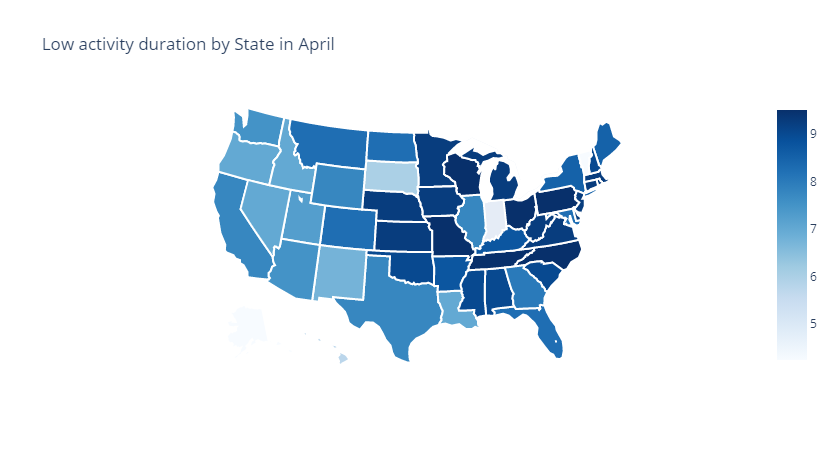

In [270]:
import matplotlib.pyplot as plt
import plotly

data = [dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = 'Blues',
        reversescale = False,
        locations = list(trough_state['state_short'].values),
        locationmode = 'USA-states',
        text = list(trough_state['duration'].values),
        z = list(trough_state['duration'].values),
        marker = dict(
            line = dict(
                color = 'rgb(255, 255, 255)',
                width = 2)
            ),
        )]

layout = dict(
         title = 'Low activity duration by State in April',
         geo = dict(
             scope = 'usa',
             projection = dict(type = 'albers usa'),
             countrycolor = 'rgb(255, 255, 255)',
             showlakes = True,
             lakecolor = 'rgb(255, 255, 255)')
         )

figure = dict(data = data, layout = layout)
plotly.offline.iplot(figure)

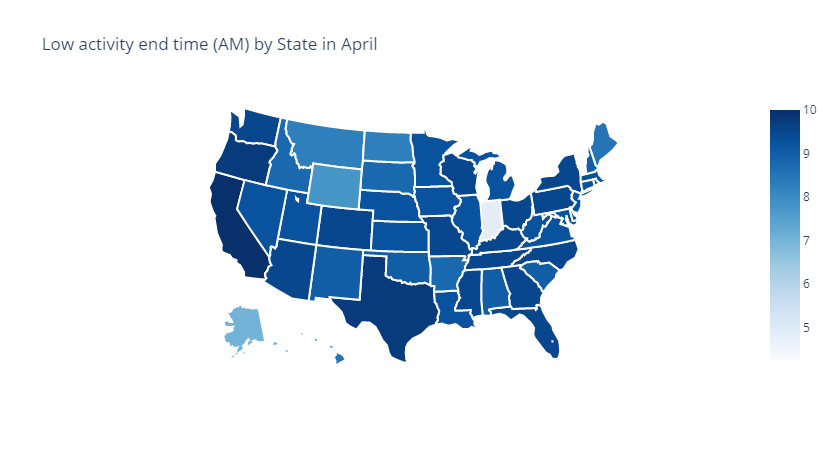

In [273]:
import matplotlib.pyplot as plt
import plotly

data = [dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = 'Blues',
        reversescale = False,
        locations = list(trough_state['state_short'].values),
        locationmode = 'USA-states',
        text = list(trough_state['end'].values),
        z = list(trough_state['end'].values),
        marker = dict(
            line = dict(
                color = 'rgb(255, 255, 255)',
                width = 2)
            ),
        )]

layout = dict(
         title = 'Low activity end time (AM) by State in April',
         geo = dict(
             scope = 'usa',
             projection = dict(type = 'albers usa'),
             countrycolor = 'rgb(255, 255, 255)',
             showlakes = True,
             lakecolor = 'rgb(255, 255, 255)')
         )

figure = dict(data = data, layout = layout)
plotly.offline.iplot(figure)

### local sunrise and sunset impact

In [232]:
pip install astral 

Note: you may need to restart the kernel to use updated packages.


In [233]:
from astral import LocationInfo
city = LocationInfo("London", "England", "Europe/London", 51.5, -0.116)
print((
    f"Information for {city.name}/{city.region}\n"
    f"Timezone: {city.timezone}\n"
    f"Latitude: {city.latitude:.02f}; Longitude: {city.longitude:.02f}\n"
))

Information for London/England
Timezone: Europe/London
Latitude: 51.50; Longitude: -0.12



In [234]:
city.observer

Observer(latitude=51.5, longitude=-0.116, elevation=0.0)

In [235]:
from astral.geocoder import add_locations, database, lookup

In [236]:
locl_info = lookup("New York", database())

In [237]:
locl_info

LocationInfo(name='New York', region='USA', timezone='US/Eastern', latitude=40.71666666666667, longitude=-74.0)

In [238]:
city = LocationInfo(locl_info.name, locl_info.region, locl_info.timezone, locl_info.latitude, locl_info.longitude)
print((
    f"Information for {city.name}/{city.region}\n"
    f"Timezone: {city.timezone}\n"
    f"Latitude: {city.latitude:.02f}; Longitude: {city.longitude:.02f}\n"
))

Information for New York/USA
Timezone: US/Eastern
Latitude: 40.72; Longitude: -74.00



In [239]:
city.observer

Observer(latitude=40.71666666666667, longitude=-74.0, elevation=0.0)

In [240]:
from astral.sun import sun
s = sun(city.observer, date=datetime.date(2009, 4, 22))
print((
    f'Dawn:    {s["dawn"]}\n'
    f'Sunrise: {s["sunrise"]}\n'
    f'Noon:    {s["noon"]}\n'
    f'Sunset:  {s["sunset"]}\n'
    f'Dusk:    {s["dusk"]}\n'
))

Dawn:    2009-04-22 09:37:22.454600+00:00
Sunrise: 2009-04-22 10:06:49.646493+00:00
Noon:    2009-04-22 16:54:34+00:00
Sunset:  2009-04-22 23:42:44.004557+00:00
Dusk:    2009-04-23 00:12:17.835932+00:00



In [241]:
# locl_info.latitude, locl_info.longitude
zone_str = tf.timezone_at(lng = locl_info.longitude, lat = locl_info.latitude)
s = sun(city.observer,
        date=datetime.date(2009, 4, 22),
        tzinfo=pytz.timezone(zone_str))
print((
    f'Dawn:    {s["dawn"]}\n'
    f'Sunrise: {s["sunrise"]}\n'
    f'Noon:    {s["noon"]}\n'
    f'Sunset:  {s["sunset"]}\n'
    f'Dusk:    {s["dusk"]}\n'
))

Dawn:    2009-04-22 05:37:22.454600-04:00
Sunrise: 2009-04-22 06:06:49.646493-04:00
Noon:    2009-04-22 12:54:34-04:00
Sunset:  2009-04-22 19:42:44.004557-04:00
Dusk:    2009-04-22 20:12:17.835932-04:00



In [242]:
s["sunrise"].hour+s["sunrise"].minute/60

6.1

In [243]:
def get_localtime_in_seconds(rows):
    coor = rows['coordinate']
    lati = coor[0]
    logi = coor[1]
    zone_str = tf.timezone_at(lng = logi, lat = lati)
    if zone_str == None:
        return None, None, None, None
    d = datetime.datetime.fromtimestamp(rows['timestamp_ms']/1000, tz=pytz.timezone(zone_str))
    h, m, s = d.hour, d.minute, d.second
    month, weekday, day_in_month = d.month, d.weekday(), d.day
    return h*3600+m*60+s, month, weekday, day_in_month

geos['time_in_second'], geos['month'], geos['weekday'], geos['day_in_month'] = zip(*geos.apply(get_localtime_in_seconds, axis=1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [244]:
geos.head()

,index,user_id,timestamp_ms,coordinate,country,state,time_in_second,month,weekday,day_in_month,label
0,5,1139323604330569729,1586527809663,"(41.481426, -87.674421)",US,Illinois,33009,4,4,10,36
1,10,27377135,1586527816658,"(33.606077, -117.86894)",US,California,25816,4,4,10,28
2,11,515108272,1586527817665,"(30.355644, -85.605166)",US,Florida,33017,4,4,10,36
3,15,118811691,1586527831663,"(40.361580000000004, -80.095586)",US,Pennsylvania,36631,4,4,10,40
4,24,1185068084010180608,1586527838658,"(36.992427, -109.060257)",US,Colorado,29438,4,4,10,32


In [245]:
# calcualte the everagy sunrise time per month in each state
# since its by city in each state capital, since need to 
capital_dic={
    'Alabama': 'Montgomery',
    'Alaska': 'Juneau',
    'Arizona':'Phoenix',
    'Arkansas':'Little Rock',
    'California': 'Sacramento',
    'Colorado':'Denver',
    'Connecticut':'Hartford',
    'Delaware':'Dover',
    'Florida': 'Tallahassee',
    'Georgia': 'Atlanta',
    'Hawaii': 'Honolulu',
    'Idaho': 'Boise',
    'Illinois': 'Springfield',
    'Indiana': 'Indianapolis',
    'Iowa': 'Des Moines',
    'Kansas': 'Topeka',
    'Kentucky': 'Frankfort',
    'Louisiana': 'Baton Rouge',
    'Maine': 'Augusta',
    'Maryland': 'Annapolis',
    'Massachusetts': 'Boston',
    'Michigan': 'Lansing',
    'Minnesota': 'Saint Paul',
    'Mississippi': 'Jackson',
    'Missouri': 'Jefferson City',
    'Montana': 'Helena',
    'Nebraska': 'Lincoln',
    'Nevada': 'Carson City',
    'New Hampshire': 'Concord',
    'New Jersey': 'Trenton',
    'New Mexico': 'Santa Fe',
    'New York': 'Albany',
    'North Carolina': 'Raleigh',
    'North Dakota': 'Bismarck',
    'Ohio': 'Columbus',
    'Oklahoma': 'Oklahoma City',
    'Oregon': 'Salem',
    'Pennsylvania': 'Harrisburg',
    'Rhode Island': 'Providence',
    'South Carolina': 'Columbia',
    'South Dakota': 'Pierre',
    'Tennessee': 'Nashville',
    'Texas': 'Austin',
    'Utah': 'Salt Lake City',
    'Vermont': 'Montpelier',
    'Virginia': 'Richmond',
    'Washington': 'Olympia',
    'West Virginia': 'Charleston',
    'Wisconsin': 'Madison',
    'Wyoming': 'Cheyenne',
    'Washington, D.C.': 'Washington DC'
}

In [246]:
from astral.geocoder import add_locations, database, lookup

state_list = trough_state['state']
for state in state_list:
    print(state, (capital_dic[state]))
    
    locl_info = lookup(capital_dic[state], database())

    city = LocationInfo(locl_info.name, locl_info.region, locl_info.timezone, locl_info.latitude, locl_info.longitude)
    print((
        f"Information for {city.name}/{city.region}\n"
        f"Timezone: {city.timezone}\n"
        f"Latitude: {city.latitude:.02f}; Longitude: {city.longitude:.02f}\n"
    ))


Illinois Springfield
Information for Springfield/USA
Timezone: US/Central
Latitude: 39.78; Longitude: -89.65

California Sacramento
Information for Sacramento/USA
Timezone: US/Pacific
Latitude: 38.55; Longitude: -121.47

Florida Tallahassee
Information for Tallahassee/USA
Timezone: US/Eastern
Latitude: 30.45; Longitude: -84.27

Pennsylvania Harrisburg
Information for Harrisburg/USA
Timezone: US/Eastern
Latitude: 40.27; Longitude: -76.87

Colorado Denver
Information for Denver/USA
Timezone: US/Mountain
Latitude: 39.73; Longitude: -104.98

Minnesota Saint Paul
Information for Saint Paul/USA
Timezone: US/Central
Latitude: 44.93; Longitude: -93.08

Kansas Topeka
Information for Topeka/USA
Timezone: US/Central
Latitude: 39.05; Longitude: -95.68

Wisconsin Madison
Information for Madison/USA
Timezone: US/Central
Latitude: 43.07; Longitude: -89.40

Washington Olympia
Information for Olympia/USA
Timezone: US/Pacific
Latitude: 47.03; Longitude: -122.88

Texas Austin
Information for Austin/USA
T

In [247]:
#　calculate the avg sunrise time in april in every steate as an example

In [248]:
import calendar
all_day = []
for date in calendar.monthcalendar(2020, 4):
    all_day += date

In [249]:
all_day = np.array(all_day)
all_day = all_day[all_day!=0]

In [250]:
all_day

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [251]:
zone_str = tf.timezone_at(lng = locl_info.longitude, lat = locl_info.latitude)
tzinfo=pytz.timezone(zone_str)


In [252]:
from astral.geocoder import add_locations, database, lookup
avg_sun_rise_dict =dict()
avg_sun_set_dict = dict()

state_list = trough_state['state']
for state in state_list:
    print(state, (capital_dic[state]))
    
    locl_info = lookup(capital_dic[state], database())
    zone_str = tf.timezone_at(lng = locl_info.longitude, lat = locl_info.latitude)
    
    city = LocationInfo(locl_info.name, locl_info.region, 
                        locl_info.timezone, locl_info.latitude, 
                        locl_info.longitude)
    sun_rise_hr = 0
    sun_set_hr = 0
    for day in all_day:
        s = sun(city.observer, date=datetime.date(2020, 4, day),tzinfo=pytz.timezone(zone_str))
        sun_rise_hr += s["sunrise"].hour+s["sunrise"].minute/60
        sun_set_hr += s["sunset"].hour+s["sunset"].minute/60
        
    avg_sun_rise_dict[state] = sun_rise_hr/len(all_day)
    avg_sun_set_dict[state] = sun_set_hr/len(all_day)


Illinois Springfield
California Sacramento
Florida Tallahassee
Pennsylvania Harrisburg
Colorado Denver
Minnesota Saint Paul
Kansas Topeka
Wisconsin Madison
Washington Olympia
Texas Austin
North Carolina Raleigh
Alaska Juneau
Ohio Columbus
Missouri Jefferson City
New York Albany
Alabama Montgomery
Tennessee Nashville
Oregon Salem
Virginia Richmond
New Jersey Trenton
Nebraska Lincoln
Michigan Lansing
New Mexico Santa Fe
Massachusetts Boston
Maryland Annapolis
South Carolina Columbia
West Virginia Charleston
Georgia Atlanta
Rhode Island Providence
Indiana Indianapolis
Oklahoma Oklahoma City
Iowa Des Moines
Louisiana Baton Rouge
Arkansas Little Rock
Delaware Dover
Utah Salt Lake City
Maine Augusta
Connecticut Hartford
South Dakota Pierre
Arizona Phoenix
Kentucky Frankfort
Mississippi Jackson
Nevada Carson City
New Hampshire Concord
Idaho Boise
Vermont Montpelier
Montana Helena
Hawaii Honolulu
North Dakota Bismarck
Wyoming Cheyenne
Washington, D.C. Washington DC


In [253]:
avg_sun_rise_df = pd.DataFrame(data=avg_sun_rise_dict.values(), index = avg_sun_rise_dict.keys())
avg_sun_set_df = pd.DataFrame(data=avg_sun_set_dict.values(), index = avg_sun_set_dict.keys())

In [254]:
avg_sun_rise_df = avg_sun_rise_df.rename(columns={0:'avg_sunrise'})
avg_sun_rise_df = avg_sun_rise_df.reset_index()
avg_sun_rise_df =avg_sun_rise_df.rename(columns={'index': 'state'})

In [255]:
avg_sun_set_df = avg_sun_set_df.rename(columns={0:'avg_sunset'})
avg_sun_set_df = avg_sun_set_df.reset_index()
avg_sun_set_df =avg_sun_set_df.rename(columns={'index': 'state'})

In [261]:
trough_state_combined = trough_state.merge(avg_sun_rise_df, on='state')
trough_state_combined = trough_state_combined.merge(avg_sun_set_df, on='state')


In [262]:
trough_state_combined.head()

,state,duration,start,end,state_short,avg_sunrise,avg_sunset
0,Illinois,7.75,1.50,9.25,IL,6.327778,19.625000
1,California,7.75,2.25,10.00,CA,6.471667,19.715556
2,Florida,8.25,1.25,9.50,FL,7.145000,20.081111
3,Pennsylvania,9.50,0.00,9.50,PA,6.465556,19.775556
4,Colorado,8.25,1.25,9.50,CO,6.350000,19.641667


In [263]:
trough_state_combined[['duration','avg_sunrise','avg_sunset','end','start']].corr()

,duration,avg_sunrise,avg_sunset,end,start
duration,1.000000,0.216084,0.012272,0.640288,-0.696608
avg_sunrise,0.216084,1.000000,0.723349,0.276277,-0.021705
avg_sunset,0.012272,0.723349,1.000000,0.007130,-0.009228
end,0.640288,0.276277,0.007130,1.000000,0.105071
start,-0.696608,-0.021705,-0.009228,0.105071,1.000000


In [269]:
from scipy import stats
stats.pearsonr(trough_state_combined['duration'], trough_state_combined['avg_sunrise'])

(0.2160844138645867, 0.1277710597187041)

In [267]:
stats.pearsonr(trough_state_combined['duration'], trough_state_combined['end'])

(0.6402877570310103, 4.1992793797318565e-07)

In [268]:
stats.pearsonr(trough_state_combined['avg_sunset'], trough_state_combined['start'])

(-0.0092284657395748, 0.9487537237264624)